In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from cgpm2.flexible_rowmix import FlexibleRowMixture
from cgpm2.product import Product
from cgpm2.crp import CRP
from cgpm2.normal import Normal
from cgpm2.transition_hypers import transition_hypers
from cgpm2.transition_hypers import transition_hyper_grids
from cgpm2.walks import get_cgpms_by_output_index
from cgpm2.transition_rows import transition_rows
from cgpm2.transition_views import transition_cgpm_view_assigments

In [4]:
prng = np.random.RandomState(2)

### Basic univariate 3 component mixture 

In [5]:
data0 = prng.normal(loc=0, scale=2, size=20)
data1 = prng.normal(loc=30, scale=1, size=20)
data2 = prng.normal(loc=-30, scale=1, size=20)

In [6]:
data = np.concatenate((data0, data1, data2))

In [7]:
infinite_mixture = FlexibleRowMixture(
    cgpm_row_divide=CRP([-1], [], rng=prng),
    cgpm_components_base=Normal([0], [], rng=prng),
    rng=prng)

In [8]:
for rowid, value in enumerate(data):
    infinite_mixture.incorporate(rowid, {0: value})

In [9]:
grids = {
    0  : transition_hyper_grids(get_cgpms_by_output_index(infinite_mixture, 0), 30),
    -1 : transition_hyper_grids(get_cgpms_by_output_index(infinite_mixture, -1), 30)
}

In [10]:
cgpms = {
    0: get_cgpms_by_output_index(infinite_mixture, 0),
    -1 : get_cgpms_by_output_index(infinite_mixture, -1),
}

In [11]:
%%timeit -n1 -r1
for step in xrange(500):
    print '\r%d' % (step,),
    import sys; sys.stdout.flush()
    rowids = prng.permutation(range(len(data)))
    for rowid in rowids:
        transition_rows(infinite_mixture, rowid, prng)
    for output in infinite_mixture.outputs:
        transition_hypers(cgpms[output], grids[output], prng)

499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1 loop, best of 1: 15.5 s per loop



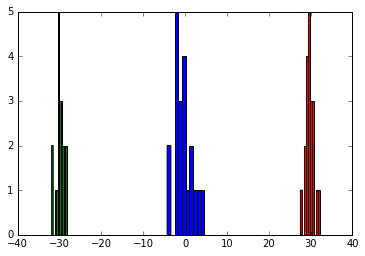

In [12]:
assignments = infinite_mixture.cgpm_row_divide.data
counts = infinite_mixture.cgpm_row_divide.counts
fig, ax = plt.subplots()
for cluster in counts:
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.hist(data[rowids])

In [13]:
samples = infinite_mixture.simulate(None, [-1,0], N=100)

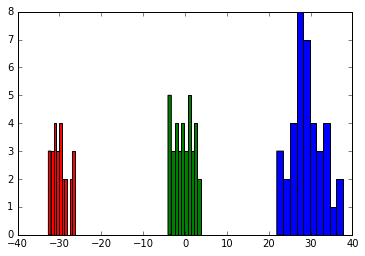

In [14]:
fig, ax = plt.subplots()
zs = set([s[-1] for s in samples])
for z in zs:
    xs = [s[0] for s in samples if s[-1] == z]
    ax.hist(xs)

#### Compare to CGPM

In [15]:
from cgpm.crosscat.state import State
state = State(X=np.reshape(data, (len(data),1)), outputs=[0], cctypes=['normal'], rng=prng)
view = state.views[0]

In [16]:
%%timeit -n1 -r1
view.transition(N=1)

1 loop, best of 1: 276 ms per loop


### Basic bivariate 2 component mixture with DPMM 

In [17]:
infinite_mixture = FlexibleRowMixture(
    cgpm_row_divide=CRP([-1], [], rng=prng),
    cgpm_components_base=Product([
        Normal([0], [], rng=prng),
        Normal([1], [], rng=prng),
    ]),
    rng=prng)

In [18]:
df = pd.read_csv('resources/two_clusters.csv', index_col=False)

In [19]:
df.loc[0,'x'] = df.loc[50,'y'] = np.nan
df.loc[10,'x'] = df.loc[30,'y'] = np.nan
df.loc[33,'x'] = df.loc[33,'y'] = np.nan

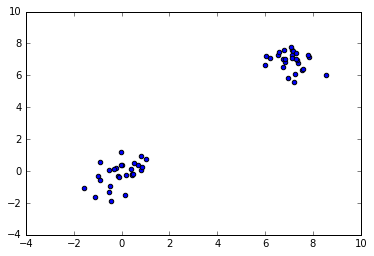

In [20]:
fig, ax = plt.subplots()
ax.scatter(df.x, df.y)

In [21]:
for rowid, row in df.iterrows():
    infinite_mixture.incorporate(rowid, {0: row.x, 1: row.y})

In [22]:
grids = {
    -1 : transition_hyper_grids(get_cgpms_by_output_index(infinite_mixture, -1), 30),
    0  : transition_hyper_grids(get_cgpms_by_output_index(infinite_mixture, 0), 30),
    1  : transition_hyper_grids(get_cgpms_by_output_index(infinite_mixture, 1), 30),
}
cgpms = {
    -1 : get_cgpms_by_output_index(infinite_mixture, -1),
    0: get_cgpms_by_output_index(infinite_mixture, 0),
    1: get_cgpms_by_output_index(infinite_mixture, 1),
}

In [23]:
%%timeit -n1 -r1
for step in xrange(500):
    print '\r%d' % (step,),
    import sys; sys.stdout.flush()
    rowids = prng.permutation(range(len(data)))
    for rowid in rowids:
        transition_rows(infinite_mixture, rowid, prng)
    for output in infinite_mixture.outputs:
        transition_hypers(cgpms[output], grids[output], prng)

499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1 loop, best of 1: 19.2 s per loop



OrderedDict([(0, 30), (6, 30)])


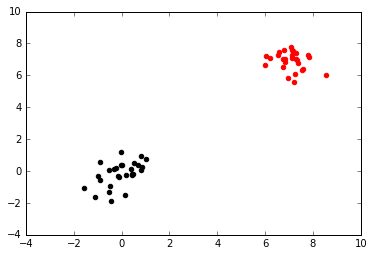

In [24]:
assignments = infinite_mixture.cgpm_row_divide.data
counts = infinite_mixture.cgpm_row_divide.counts
print counts
fig, ax = plt.subplots()
for cluster,color in zip(counts, ['r','k','g','y','b']):
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.scatter(df.loc[rowids].x, df.loc[rowids].y, color=color)

In [25]:
samples = infinite_mixture.simulate(None, [-1,0, 1], N=100)

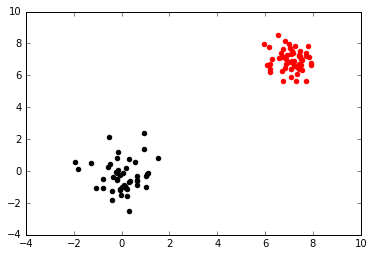

In [26]:
fig, ax = plt.subplots()
zs = set([s[-1] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[0] for s in samples if s[-1] == z]
    ys = [s[1] for s in samples if s[-1] == z]
    ax.scatter(xs,ys, color=c)

### Basic bivariate 2 component mixture with CrossCat and category inference

In [27]:
from cgpm2.transition_views import get_cgpm_view_proposals
from cgpm2.transition_views import get_cgpm_data_logp
from cgpm2.transition_views import get_cgpm_current_view_index
from cgpm2.transition_views import log_pflip
from cgpm2.transition_views import remove_cgpm

In [28]:
crosscat = Product([
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-1], [], rng=prng),
        cgpm_components_base=Product([
            Normal([0], [], rng=prng),
        ]),
        rng=prng),
    FlexibleRowMixture(
        cgpm_row_divide=CRP([-2], [], rng=prng),
        cgpm_components_base=Product([
            Normal([1], [], rng=prng),
        ]),
        rng=prng),
])

In [29]:
for rowid, row in df.iterrows():
    crosscat.incorporate(rowid, {0: row.x, 1: row.y})

In [30]:
grids = {
    -2 : transition_hyper_grids(get_cgpms_by_output_index(crosscat, -2), 30),
    -1 : transition_hyper_grids(get_cgpms_by_output_index(crosscat, -1), 30),
    0  : transition_hyper_grids(get_cgpms_by_output_index(crosscat, 0), 30),
    1  : transition_hyper_grids(get_cgpms_by_output_index(crosscat, 1), 30),
}

In [31]:
def get_latest_cgpms(crosscat):
    crp_outputs = [c.cgpm_row_divide.outputs[0] for c in crosscat.cgpms]
    crp_cgpms = {output : get_cgpms_by_output_index(crosscat, output) for output in crp_outputs}
    data_cgpms =  {
        0  : get_cgpms_by_output_index(crosscat, 0),
        1  : get_cgpms_by_output_index(crosscat, 1),
    }
    data_cgpms.update(crp_cgpms)
    return data_cgpms

In [32]:
for step in xrange(100):
    cgpms = get_latest_cgpms(crosscat)
    rowids = prng.permutation(range(len(df)))
    for view in crosscat.cgpms:
        for rowid in rowids:
            transition_rows(view, rowid, prng)
    for output in crosscat.outputs:
        transition_hypers(cgpms[output], grids[output], prng)
    for output in [0,1]:
        crosscat = transition_cgpm_view_assigments(crosscat, [output])

In [33]:
assert len(crosscat.cgpms) == 1
crosscat.cgpms[0].outputs

[-2, 1, 0]

In [34]:
crp_output = crosscat.cgpms[0].cgpm_row_divide.outputs[0]
samples = crosscat.simulate(None, [crp_output,0,1], N=100)

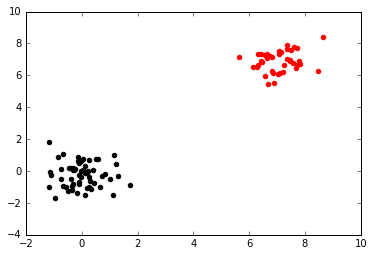

In [35]:
fig, ax = plt.subplots()
zs = set([s[crp_output] for s in samples])
for z, c in zip(zs, ['r','k','b','g']):
    xs = [s[0] for s in samples if s[crp_output] == z]
    ys = [s[1] for s in samples if s[crp_output] == z]
    ax.scatter(xs,ys, color=c)